# Recommendation Tools Individual Assignment
### Fernando Delgado

The following notebook describes a recommendation systems project that is part of a in-class kaggle competition of the following link:

https://www.kaggle.com/c/recsys-2022/overview

## Introduction

A recommender system, or a recommendation system, is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.

For this project, we put our recommendation skills to the test by applying different algorithms to the Amazon review dataset. Then we upload our solution file to Kaggle. 

In [1]:
wd = "C:/Users/fdelgado/OneDrive - IESEG/Documents/01. IESEG/16. Recommendation Systems/Individual Project/"

In [2]:
#Data manipulation
import pandas as pd 
import numpy as np

#Visualization
import matplotlib.pyplot as plt

#Recommendation Systems
import surprise
from surprise import Dataset
from surprise import Reader
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import accuracy
from surprise import SVD
from surprise import SVDpp
from surprise import CoClustering
from surprise.model_selection import GridSearchCV

from IESEGRecSys import eval

#Machine Learning
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv(wd+'data/raw/train.csv')
metadata = pd.read_csv(wd+'data/raw/metadata.csv')

## Objective
The objective of this project is to fit the best recommendation model for our dataset. To validate our model we want to obtain the lowest RMSE possible. AS a benchmark, we have a RMSE of 1.03 in Kaggle, meaning that anything lower than that value should be sufficient. 

Thus, I will fit 3 different models and compare them, in order to choose the best one in relation to their RMSE.

Root Mean Square Error is the standard deviation of the prediction errors (residuals). RMSE is a measure of how spread out these residuals are. In other words, it tells us how concentrated the data is around the line of best fit. Thus, the lower the RMSE, the better.

## Data Preparation

The dataset consists of 2 files: 
* train: user-item ratings, including review text and additional user data 
* metadata: additional item data (title, description, image_url)

First, we inspect the train dataset:

In [4]:
train.head()

,userID,overall,asin,vote,reviewText,summary,style,image
0,13527,5.0,B0002565TI,NaN,"These filters used to be sold at PetCo, but no...",Great Place to Get Filte-rs,NaN,NaN
1,14608,2.0,B0002H3ZLM,NaN,Did not work for my large- does. Returned it.,T#wo Stars,"{'Size:': ' LARGE 60-130 LBS.', 'Color:': ' BL...",NaN
2,15536,5.0,B0009YD8OC,NaN,I was pretty skeptical that this would be easy...,stops pulling in a 6 month 60{ pound pup great!,NaN,NaN
3,12868,5.0,B001VPA9OK,NaN,Works great for groom-ing my dog. A must have.,Five /Stars,{'Color:': ' Silver'},NaN
4,181,5.0,B000K67UF2,NaN,Great cage for budgies! I cant say enough marv...,Great cage for budg{ies,"{'Size:': ' Medium', 'Pattern:': ' MO2 Cage'}",NaN


We can visualize how many times an item has been reviewd on average with the following histogram:

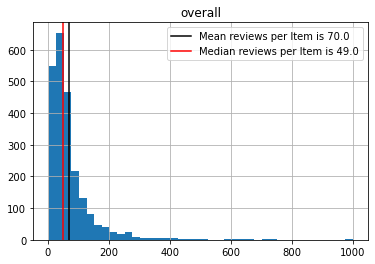

In [5]:
# average number of reviews per item
reviews_item = train.groupby('asin').agg({'overall':'count'})

#histogram
reviews_item.clip(upper=1000).hist(bins=40)

plt.axvline(x=reviews_item.mean().item(), label=f"Mean reviews per Item is {reviews_item.mean().item():.1f}", c="k")
plt.axvline(x=reviews_item.median().item(), label=f"Median reviews per Item is {reviews_item.median().item():.1f}", c="r")
plt.legend()

Given that our items have an average number of 70 reviews, we decide to filter out all of those items that have been reviewed less than 10 times as it may bias our models.

In [6]:
# filter items with 10+ ratings
ratings_count = train["asin"].value_counts()
min_count = 10
items_filter = list(ratings_count[ratings_count >= min_count].index)
train = train[train["asin"].isin(items_filter)].reset_index(drop=True)

print(f"Removed {len(ratings_count) - (ratings_count > min_count).sum()} items")

Removed 85 items


Moreover, we do the same visualization for ratings per user and filter out all of those users with less than 3 ratings witin the dataset. 

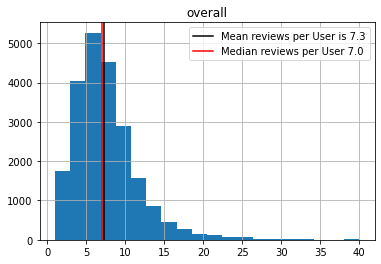

In [7]:
# average number of items rated by users
reviews_user = train.groupby('userID').agg({'overall':'count'})

#histogram
reviews_user.clip(upper=40).hist(bins=20)

plt.axvline(x=reviews_user.mean().item(), label=f"Mean reviews per User is {reviews_user.mean().item():.1f}", c="k")
plt.axvline(x=reviews_user.median().item(), label=f"Median reviews per User {reviews_user.median().item():.1f}", c="r")
plt.legend()

In [8]:
# filter users with 5+ ratings
ratings_count = train["userID"].value_counts()
min_count = 3
users_filter = list(ratings_count[ratings_count >= min_count].index)
train = train[train["userID"].isin(users_filter)].reset_index(drop=True)

print(f"Removed {len(ratings_count) - (ratings_count > min_count).sum()} users")

Removed 3503 users


Finally, in order to run our collaborative filtering models, we need a table with only 3 columns: UserID, item(asin) and rating(overall).

In [9]:
train = train[['userID', 'asin', 'overall']]
train.head()

,userID,asin,overall
0,13527,B0002565TI,5.0
1,14608,B0002H3ZLM,2.0
2,15536,B0009YD8OC,5.0
3,12868,B001VPA9OK,5.0
4,181,B000K67UF2,5.0


### Train/Test Split

Moving forward, before fitting any model,we split our train dataset into another train and test split, following a 70/30 ratio. Then we apply reader from surprise package in order to run our collaborative filtering models.

In [10]:
# train-test split
train, test = train_test_split(train, test_size=0.3)

reader = Reader(rating_scale=(1, 5))
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

## Collaborative Filtering Models

Collaborative Filtering does not need the features of the items to be specified, it simply works with the user id, artist id, and the particular rating. When it creates a recommendation, it considers another user’s input to recommend another particular user. For example, if a user A has similar behavior than user B, then it is likely that the things that user A likes, will be enjoyed by user B.

There are many different types of collaborative filtering methods, but for this project we will run 4:
* Cosine User-based
* ALS
* SVD
* SVD++

### User-Based
User-based collaborative filtering works by estimating a user’s rating based on a similar set of users who have a similar behavior as our target user. The simple approach would be to make an average of other similar users on given product and assign it to our prediction target.

On the options we specify a cosine user-based model with a standard of 20 most similar users with a minumum of 5. 

In [11]:
# set option to cosine similarity and user-based collaborative filtering
options = {'name':'cosine', 'user_based':True}

# select 20 most similar users (min 5)
ub = KNNBasic(k=20, min_k=5, sim_options=options, random_state=42)

# fit on training set
ub.fit(df_train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Once the model is fitted, we evaluate our prediction on or test split and end up with our first RMSE 

In [12]:
#Evaluate Test Set
pred = ub.test(df_test)
accuracy.rmse(pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 1.1571
Impossible: 0.5629


In [13]:
userbased_eval = eval.evaluate(prediction=pred, topn=5, rating_cutoff=4, excl_impossible=True)

#Rename column 
userbased_col = userbased_eval.rename(columns={"value": "cosine_userbased"})
userbased_col

Excluded 26743 (47511) samples. 20768 remaining ...
Excluded 26743 (47511) samples. 20768 remaining ...


,cosine_userbased
RMSE,1.123548
MAE,0.826690
Recall,0.855558
Precision,0.839475
F1,0.847440
NDCG@5,0.920382


# ALS
Alternating Least Squares is a model that based on matrix factorization. It used a Weighted-Lambda-Regularization. It factors the 3 following matrices: The user to item, item to feature and user to feature matrix. The goal is to understand the factors that define the user to item ratings. It will then find an optimal factor weight to reduce to the minimum the least squares.

In this example we run a simple ALS with 30 epochs:

In [14]:
options = {"method": "als", "n_epochs": 30}
als = BaselineOnly(bsl_options=options)

# fit on training set
als.fit(df_train)

pred = als.test(df_test)
accuracy.rmse(pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

Estimating biases using als...
RMSE: 1.0900
Impossible: 0.0000


In [15]:
als_eval = eval.evaluate(prediction=pred, topn=5, rating_cutoff=4, excl_impossible=True)
als_col = als_eval.rename(columns={"value": "als"})
als_col

Excluded 0 (47511) samples. 47511 remaining ...
Excluded 0 (47511) samples. 47511 remaining ...


,als
RMSE,1.090019
MAE,0.821239
Recall,0.895110
Precision,0.848024
F1,0.870931
NDCG@5,0.880785


# SVD

Singular Value Decomposition uses dimension reduction by using matrix decomposition. The SVD’s purpose is to propose multivariate data analysis. This simplifies the data, removes noise but can also be used to improve algorithm results. 

In this particular model we run a standar SVD model with 20 factors:

In [16]:
# select 20 factors and use probabilistic matrix factorization (no bias)
svd = SVD(n_factors=20, random_state=42)

# fit on training set
svd.fit(df_train)

pred = svd.test(df_test)
accuracy.rmse(pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 1.0829
Impossible: 0.0000


In [17]:
svd_eval = eval.evaluate(prediction=pred, topn=5, rating_cutoff=4, excl_impossible=True)
svd_col = svd_eval.rename(columns={"value": "svd"})
svd_col

Excluded 0 (47511) samples. 47511 remaining ...
Excluded 0 (47511) samples. 47511 remaining ...


,svd
RMSE,1.082948
MAE,0.802318
Recall,0.855912
Precision,0.858177
F1,0.857043
NDCG@5,0.880782


### SVD++

Reading into surprise's documentation, we run a small variation to SVD named SVD++ that runs slower but usually finds slightly better results than the normal SVD.

The way to interpret SVD++ is that it is including the effect of the "implicit" information. By understanding that a user rates an item is in itself an indication of preference. In other words, chances that the user "likes" an item the user has rated are higher than for a random not-rated item. 


In [19]:
svdpp = SVDpp(n_factors=200 ,
         n_epochs = 150, 
         lr_all = 0.01, 
         reg_all = 0.1, 
         random_state=42)

# fit on training set
svdpp.fit(df_train)

svdpp_pred = svdpp.test(df_test)
accuracy.rmse(svdpp_pred)

# impossible predictions
perc_impossible = np.sum([1 for i in svdpp_pred if i.details["was_impossible"]]) / len(svdpp_pred)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 1.0649
Impossible: 0.0000


In [20]:
svdpp_eval = eval.evaluate(prediction=pred, topn=5, rating_cutoff=4, excl_impossible=True)
svdpp_col = svdpp_eval.rename(columns={"value": "svdpp"})
svdpp_col

Excluded 0 (47511) samples. 47511 remaining ...
Excluded 0 (47511) samples. 47511 remaining ...


,svdpp
RMSE,1.082948
MAE,0.802318
Recall,0.855912
Precision,0.858177
F1,0.857043
NDCG@5,0.880782


### Overview

After running our 4 different models, we create an overview table to compare. In this case, we focus on the RMSE scores since it's our main target for the Kaggle competition. SVD and SVD++ are our best fit. They are both close to the benchmark of 1.03 but still need some work. 

In [21]:
overview = pd.concat([userbased_col, svd_col, als_col, svdpp_col], axis=1)
overview

,cosine_userbased,svd,als,svdpp
RMSE,1.123548,1.082948,1.090019,1.082948
MAE,0.826690,0.802318,0.821239,0.802318
Recall,0.855558,0.855912,0.895110,0.855912
Precision,0.839475,0.858177,0.848024,0.858177
F1,0.847440,0.857043,0.870931,0.857043
NDCG@5,0.920382,0.880782,0.880785,0.880782


## Param Grid to Improve RMSE

On all of the methods above, we ran very standard parameters for each model but, they can be improved by assigning different parameters to each one of them to get the best possible results. 

In this case, we run a SVD, SVD++, and ALS parameter grid to find the best parameters. In essence, it runs the same model several times with all of the possible combinations of parameters to obtain the best fit. Depending on how many parameters we specify, it may take up to several hours to complete. 

### SVD param grid
Warning: this code may take up to +5 hours to run depending on how many parameters we specify:

In [22]:
#df_auto = Dataset.load_from_df(train, reader)

#param_grid = {'n_factors': [50,100,200,250], 
#              'n_epochs':[20,100,150,250], 
#              'lr_all':[0.005,0.01],
#              'reg_all':[0.1,0.2,0.5]}

#gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, refit=True)

#gs.fit(df_auto)

# combination of parameters with the best RMSE
#print(gs.best_params['rmse'])
#print(gs.best_score['rmse'])

{'n_factors': 250, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}
1.0856310783822753


### SVD++ Param Grid

Note: this is commented out to be able to run the whole notebook without taking too much time

In [23]:
# df_auto = Dataset.load_from_df(train, reader)

# param_grid = {'n_factors': [50,100,200,250], 
#               'n_epochs':[20,100,120,150,200,250], 
#               'lr_all':[0.005,0.01],
#               'reg_all':[0.1,0.2,0.5]}

# gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3, refit=True)

# gs.fit(df_auto)

# # combination of parameters with the best RMSE
# print(gs.best_params['rmse'])
# print(gs.best_score['rmse'])

### ALS Param Grid

In [24]:
#als_data = Dataset.load_from_df(train, reader)

#param_grid = {'bsl_options': {'n_epochs':[30,50, 70],
#                              'reg_u':[7, 10, 15],
#                              'reg_i':[10, 13, 20]}}

#gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3)

#gs.fit(als_data)

#print(gs.best_params['rmse'])
#print(gs.best_score['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

## Final Model

Running parameter grid is a trial and error. Here we ran several times with different parameters while adjusting/adding/removing new parameters. Basically, we run predictions on our dataset with all of our different results for SVD, SVDpp, and ALS to upload it to Kaggle.

It is tricky because we get good RMSE in the jupyter notebook but a much higher one in kaggle(or viceversa). You may never know the real result until you submit your prediction to Kaggle. Thus, we made several submissions to find the best parameters. 

After several runs, we find the following SVDpp model as the best one:

In [31]:
svd = SVDpp(n_factors=200 ,
         n_epochs = 100, 
         lr_all = 0.01, 
         reg_all = 0.1,  
         random_state=42)

# fit on training set
svd.fit(df_train)

# predict
svd_pred = svd.test(df_test)
accuracy.rmse(svd_pred)

# impossible predictions
perc_impossible = np.sum([1 for i in svd_pred if i.details["was_impossible"]]) / len(svd_pred)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 1.0656
Impossible: 0.0000


We had a RMSE of 1.0656 but in kaggle it was 1.012 (and it may still change once its fitted in the full data).

### Predict on Test set

Finally, we implement our prediction on the test set and prepare to export our file:

In [32]:
#Load data
test_students = pd.read_csv(wd+'data/raw/test_students.csv')

#format table to export
test_students = test_students[['userID','asin']]
test_students['overall'] = 0

#cast to tuple
test_students = test_students.to_records(index=False)

In [33]:
#predict on test set
result = svd.test(test_students)

#Create Dataframe
result = pd.DataFrame(result)

#Clean Column names and format
result['ID']= result['uid'].astype(str)+result['iid'].astype(str)
result = result[['ID','est']]
result = result.rename(columns={"est": "overall"})

result.head()

,ID,overall
0,21069B00BFK2B24,3.539585
1,3506B00ZK0Y7R2,3.816846
2,21907B0002AQPA2,3.947712
3,14092B0002DHXX2,4.544069
4,3085B0006VB3SQ,4.415539


In [35]:
#Export to csv
result.to_csv(wd+'data/final/submission_14.csv', index=False)

## Conclusion 

Running Recommendation systems for this project was a lot of trial-error. Right from the start, I decided to work with collaborative filtering because I was getting good results in comparisson with the kaggle benchmark. Thus, running param grids to improve my score was the best solution. 

However, it was not that easy. Param Grid can take up to 24 hours or more depending on how many parameters you are running and how large is your data. Thus, making tests and trying out different parameters took several days until i finally found the right one that improved my model. 

Also, i noticed that by resetting the whole notebook and re-doing the train/test split could change my scores drastically given that it is always a random split. 

Moreover, as further steps for this project I could run a content-based model and a hybrid model in order to compare their performance versus the collaborative filtering.